In [1]:
import sys
import random
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
# all data will be read from or stored under this folder
DATA_DIR = Path('data')

### Step 1: generate dummy measurement data
- specify the time range (start_time, end_time)
- specify frequency in seconds
- specify list of measurements names
- generate timestamps within the time range with the frequency
- for measurement name generate a distribution of measurement values
- merge all of the data into a single dataframe and save into file

In [3]:
def normal_dist(lower=0, upper=1, mean=0.5, stdev=0.1, n=100):
    '''
    generate normal distribution of size n in (lower,upper) range with a given mean and stdev
    '''
    return truncnorm.rvs((lower-mean)/stdev, (upper-mean)/stdev, loc=mean, scale=stdev, size=n)


def generate_measurements(start_time, end_time, frequency_seconds, names=["m1"]):
    '''
    generate measurements
    '''
    # convert start and end times to timestamps
    start_time = str2date(start_time)
    end_time = str2date(end_time)
    
    data = {}

    # generate timestamps for individual measurements between start_time and end_time with frequency in seconds
    timestamp2datetime = lambda x: pd.to_datetime(x, unit='s')    
    times = [timestamp2date(x) for x in range(nano2sec(start_time.value), nano2sec(end_time.value), frequency_seconds)]
    data['timestamp'] = times
    
    # for each feature generate measurement data from normal distribution
    for name in names:
        data[name] = normal_dist(lower=0, upper=100, mean=50, stdev=15, n=len(times))
    
    return pd.DataFrame(data)

# basic date converters between string (e.g. '2018-01-01 00:00:00'), datetime and unix timestamp
str2date = lambda x: pd.Timestamp(x) # string to datetime
timestamp2date = lambda x: pd.to_datetime(x, unit='s') # convert unix timestamp to datetime with second resolution
nano2sec = lambda x: int(x / 10 ** 9) # convert nanoseconds to seconds
str2timestamp = lambda x: nano2sec(str2date(x).value)

# time ranges: 1m - 1 month, 1w - 1 week, 1m - 1 month, 1y - 1 year
time_ranges = {
    '1d': ('2018-01-01 00:00:00', '2018-01-01 23:59:59'),
    '1w': ('2018-01-01 00:00:00', '2018-01-07 23:59:59'),
    '1m': ('2018-01-01 00:00:00', '2018-01-31 23:59:59'),
    '1y': ('2018-01-01 00:00:00', '2018-12-31 23:59:59')}    

# specify which time range to use
time_range_key = '1d'
#time_range_key = '1m'
#time_range_key = '1y'
start_time = time_ranges[time_range_key][0]
end_time = time_ranges[time_range_key][1]

# measurements frequency
freq = 30

# measurement names
names = ['m1', 'm2', 'm3', 'm4', 'm5']

# generate measurements
measurements = generate_measurements(start_time, end_time, freq, names)

# save to file
data_file_name = DATA_DIR / F"measurements-dummy-{time_range_key}.csv"
measurements.to_csv(data_file_name, index=False)

measurements.head()

,timestamp,m1,m2,m3,m4,m5
0,2018-01-01 00:00:00,66.780494,65.217221,48.842714,51.054600,56.330693
1,2018-01-01 00:00:30,57.675873,82.594139,67.128019,34.646194,49.404110
2,2018-01-01 00:01:00,65.254882,51.663527,49.967143,53.994720,27.718782
3,2018-01-01 00:01:30,48.868397,23.830365,63.191482,53.418901,61.711849
4,2018-01-01 00:02:00,55.270477,16.035617,46.767995,31.731472,60.183277


In [4]:
measurements.describe(percentiles=[.1, .25, 0.5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
m1,2880.0,50.255549,15.034401,1.017740,31.279634,40.210207,49.855128,60.304664,70.019719,99.264672
m2,2880.0,50.232817,15.089256,1.343985,30.654365,40.020723,50.398855,60.661201,69.358024,97.814882
m3,2880.0,50.002071,15.251594,0.717349,30.616853,39.326593,49.967689,60.342587,69.623720,97.476216
m4,2880.0,50.047813,14.824065,1.065827,31.225044,39.695646,50.371145,60.339459,68.964498,95.406924
m5,2880.0,50.168339,15.119493,2.626763,31.014169,39.672593,50.105960,60.760581,69.611558,99.390833


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


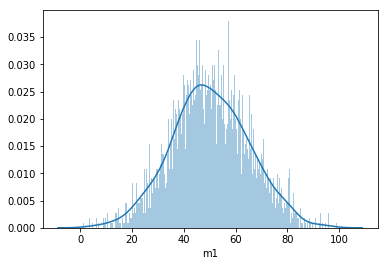

In [5]:
# plot distribution of m1
sns.distplot(measurements.m1, bins=256)

# plot correlations
#sns.pairplot(measurements)

### Step 2: generate production data
- specify a time interval (start_time, end_time)
- generate N production events each with an end_time and duration of 1.5h

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


,duration,finished_time,efficiency
0,90,2018-01-01 03:00:04,51.108762
1,90,2018-01-01 04:30:06,27.203295
2,90,2018-01-01 06:00:08,98.806322
3,90,2018-01-01 09:00:12,50.763437
4,90,2018-01-01 10:30:14,53.172586


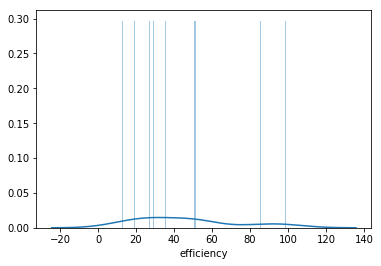

In [7]:
def sample_with_min_distance(min_value=10, max_value=150, size=10, dist=15):
    all_values = range(min_value, max_value + 1, dist + 1)
    return sorted(np.random.choice(all_values, size=size, replace=False))

def generate_production_data(start_time, end_time, prod_count, duration_min=90, feature_names=['f1']):
    # convert start and end times to timestamps
    start_time = str2date(start_time)
    end_time = str2date(end_time)
    
    data = {}
    durarion_sec = duration_min * 60
    data['duration'] = duration_min
    end_dates = [timestamp2date(x) for x in sample_with_min_distance(nano2sec(start_time.value), nano2sec(end_time.value), size=prod_count, dist=durarion_sec + 1)]
    data['finished_time'] = end_dates
    for name in feature_names:
        data[name] = normal_dist(lower=0, upper=100, mean=50, stdev=30, n=len(end_dates))
    
    return pd.DataFrame(data)

# number of production data points to generate

# generate production data with prod_count number of data points
prod_count = 1000 if time_range_key == '1y' else 100 if time_range_key == '1m' else 10
prod_data = generate_production_data(start_time, end_time, prod_count, feature_names=['efficiency'])

# save to file as csv
data_file_name = DATA_DIR / F"production-dummy-{prod_count}-{time_range_key}.csv"
prod_data.to_csv(data_file_name, index=False)

# plot distribution of m1
sns.distplot(prod_data.efficiency, bins=256)

prod_data.head()

In [8]:
prod_data.describe(percentiles=[.1, .25, 0.5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
duration,10.0,90.00000,0.000000,90.000000,90.000000,90.000000,90.000000,90.00000,90.000000,90.000000
efficiency,10.0,46.34356,27.942523,12.615963,18.421287,27.752645,43.248667,52.65663,86.888519,98.806322
